*David Schlangen, 2019-03-20*

# The Image Corpora

This notebook gives an overview of the image corpora that we have looked at so far. Many of these corpora have been used to create further annotation. Here, we only look at the corpora themselves -- that is, the types of images that can be found in them -- and the basic annotation that comes with them. Further annotations that we have looked at will be discussed in the notebooks in `03_Tasks`.

This notebook is part of a collection of notebooks. The series starts with `01_SemPics`, and continues with the notebooks in `03_Tasks`. See comments in `01_SemPics` on how best to view these notebooks.

In [1]:
# imports

from __future__ import division
import codecs
import json
# from itertools import chain, izip, permutations, combinations
# from collections import Counter, defaultdict
import configparser
import os
import random
from textwrap import fill
# import scipy
import sys
import csv
# from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [4]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = [
            'saiapr_bbdf',
            'mscoco_bbdf',
            'mscoco_catsdf',
            'cococapdf',
            'vgregdf',
            'vgimgdf',
            'vgreldf',
            'vgobjdf',
            'vgpardf', 
            'flickr_bbdf',
            'flickr_capdf',
            'flickr_objdf',
            'ade_imgdf',
            'ade_objdf',
            'cub_bbdf',
            'cub_attrdf',
            'cub_partdf',
            'cub_capdf'
           ]
df = load_dfs(preproc_path, df_names)

# a derived DF, containing only those region descriptions which I was able to resolve
df['vgpregdf'] = df['vgregdf'][df['vgregdf']['pphrase'].notnull() & 
                               (df['vgregdf']['pphrase'] != '')]

## SAIAPR TC-12: Holiday Pictures

IAPR TC-12 is a collection of  “20,000 still natural images taken from locations around the world and comprising an assorted cross-section of still natural images” \cite{Grubinger2006}. This dataset was later augmented by \cite{Escalante2010} with segmentation masks identifying objects in the images (an average of 5 objects per image). It was further augmented by \cite{Kazemzadeh2014} with expressions referring to objects in the images. (This annotation will be discussed elsewhere.)

Here's an example of an object-annotated image from the corpus. (Note that the corpus actually provides segmentation masks, which are tight boundaries around the objects. For simplicity, and since most modern methods actually take rectangular image patches as input, this is extended in our preprocessing to the smallest box that contains all pixels.) 

In [6]:
# Load mapping from category ID to category name
saiapr_cat_path = os.path.join(config.get('SAIAPR', 'saiapr_base'),
                               'SAIA_Data/benchmark/wlist.txt')

saiapr_cat = {}
with open(saiapr_cat_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        saiapr_cat[int(row[0])] = row[1]

In [7]:
# Plot one image from the corpus, together with bounding boxes around segmented objects.
ii = 112
ic = icorpus_code['saiapr']
bbs = [(bb, saiapr_cat[cat_id]) 
       for bb, cat_id in query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'cat']).values]
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

FileNotFoundError: [Errno 2] No such file or directory: '/home/patrick/ImageCorpora/IAPR_ReferIt/SAIA_Data/benchmark/saiapr_tc-12/00/images/112.jpg'

As the following random sample likely shows, this image corpus is representative of the kinds of images a tourist might take on a trip. As such, it is perhaps less representative of the kinds of surroundings one finds oneself in or things one sees most often.

In [8]:
# A random sample of 6 images from SAIAPR
all_iis = df['saiapr_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'saiapr', ii)

## Flickr30k: Events

Flickr30k \cite{youngetal:flickr30k} is a collection of 30,000 images from the online image service [Flickr](https://www.flickr.com) (then in a better shape than now), which were augmented with captions. It is an extension in size of an earlier collection, Flickr8k \cite{Hodosh:flickr8k}, and follows the same methodology:

> "The images in this data set focus on people or animals (mainly dogs) performing some action. [...] The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations. In order to avoid ungrammatical captions, we only allowed workers from the United States who had passed a brief spelling and grammar test we devised to annotate our images. Because we were interested in conceptual descriptions, annotators were asked to write sentences that describe the depicted scenes, situations, events and entities (people, animals, other objects)."  \cite{Hodosh:flickr8k}

In \cite{flickr30kent}, these captions were annotated with positions of the objects in the images that they mention (Flickr30kEntities). The following shows an example of a caption from the corpus, as it is grounded in regions in the image.

Caption: a girl wearing flip-flop sandals swinging on a swing set in a park underneath
fluffy white clouds .

With groundings:
 [/EN#3883/people A girl] wearing [/EN#3889/clothing flip-flop sandals] swinging
on [/EN#3884/other a swing] set in [/EN#3887/scene a park] underneath
[/EN#3890/other fluffy white clouds] .


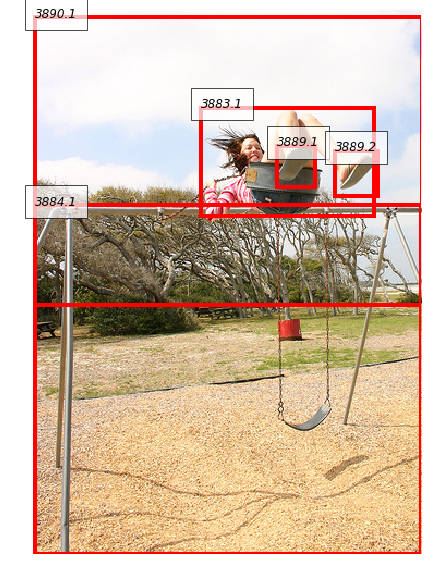

In [9]:
# example of a Flickr30k caption, with a randomly selected negative example
def flcap2bb(cap_row, bbdf):
    cap = cap_row['caption_raw'] # cap_row['caption_annotated']
    entities = cap_row['entities']
    outbb = []
    for entity in entities:
        this_bb = bbdf[bbdf['region_id'] == entity]
        for _, row in this_bb.iterrows():
            outbb.append((row['bb'], '%d.%d' % (entity, row['subregion_id'])))
    # outbb.append(([0,0,10,10], fill(cap, 40)))
    return outbb

pick_row = 2345
this_row = df['flickr_capdf'].iloc[pick_row]
ii = this_row['image_id']
print('Caption:', fill(this_row['caption_raw'], 80))
print('')
print('With groundings:\n', fill(this_row['caption_annotated'], 80))
plot_labelled_bb(get_image_filename(config, 8, ii),
                 flcap2bb(this_row, df['flickr_bbdf']), figsize=(10,10))

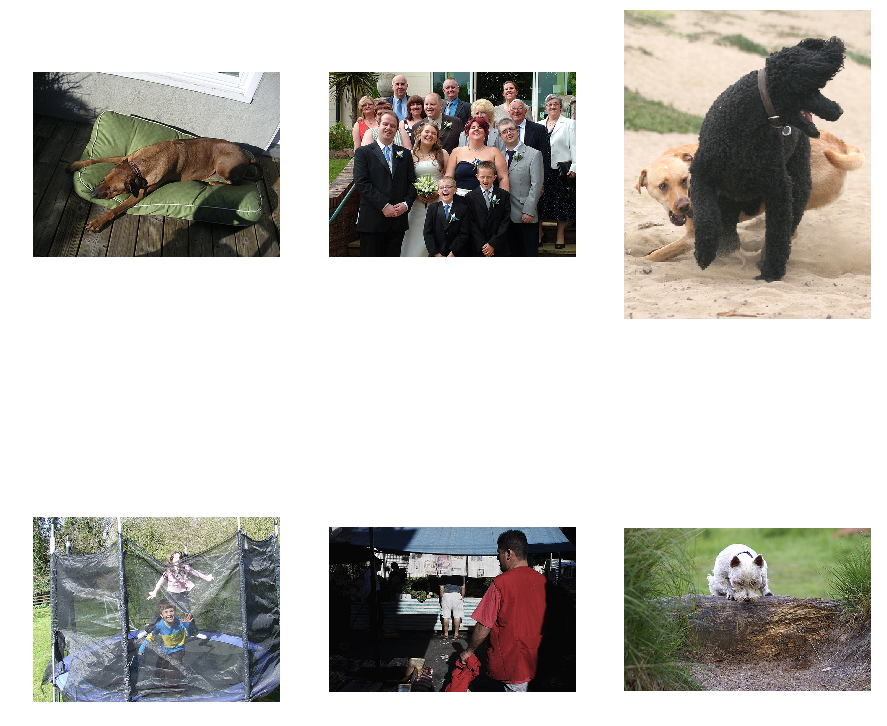

In [23]:
# A random sample of 6 images from SAIAPR
all_iis = df['flickr_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'flickr_30k', ii)

Activities are not easy to identify given static images. The following corpus takes a step back and focusses on *objects* instead.

## MS-COCO: Common Objects in Context

The “Microsoft Common Objects in Context ([MSCOCO](http://cocodataset.org/#home))” collection \cite{mscoco} contains over 300k images with object segmentations (of objects from 80 pre-specified categories), object labels, and image captions. It forms the basis of a large number of subsequent works that added all kinds of further annotations, such as complex expressions referring to one of the objects, or questions about the images, or even sequence of questions and answers. We will again discuss some of that additional material in `03_Tasks`, focussing on the original annotation here.

This dataset was constructed with the objects being in focus. The list of 80 "common objects" from various object classes (see below) was created first, and with pairs of object name and common scene type, Flickr was queried for images.

In [24]:
df['mscoco_catsdf']['supercat'].value_counts()

sports        10
animal        10
food          10
vehicle        8
indoor         7
kitchen        7
furniture      6
electronic     6
outdoor        5
accessory      5
appliance      5
person         1
Name: supercat, dtype: int64

In the selected images, the objects from these 80 types (and only those) were segmented. Additionally, a set of captions was collected for each image, with the instructions given not to start the description with "there is", not to describe unimportant details, and (in effect) not to imagine a context beyond what is visible.

A woman prepares several sub sandwiches at a deli counter.
a person behind a display glass preparing food 
A lady behind a sneeze guard making sub sandwiches.
THERE IS A WOMAN THAT IS MAKING SANDWICHES AT A DELI
A woman behind a deli counter making sub sandwiches.


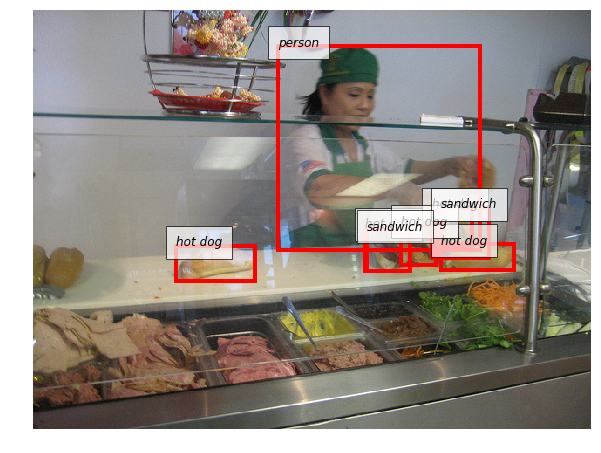

In [25]:
# plot mscoco categories on image
pick_row = 100

# easier to look up:
cococat = dict(zip(df['mscoco_catsdf'].index, df['mscoco_catsdf']['cat'].values))

ic, ii  = df['mscoco_bbdf'].iloc[pick_row][['i_corpus', 'image_id']]

for cap in query_by_id(df['cococapdf'], (icorpus_code['mscoco'], ii), 'caption'):
    print(cap)

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), ['bb', 'cat']).values
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, cococat[cat]) for b, cat in this_anno])

In [26]:
# A random sample of 6 images from MSCOCO
all_iis = df['mscoco_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'mscoco', ii)

## Visual Genome: Focus on relations between objects

This dataset by \cite{krishnavisualgenome} combines images from MSCOCO and another data set (yielding around 100k images), and augments them with "region descriptions", which are statements true about a part of an image, and resolved for the entities mentioned and their relations. These descriptions are parsed into object names and attributes, and normalised by reference to the WordNet ontology \cite{fellbaum:wordnet}. \cite{krauseetal:visgenparas} adds image description paragraphs (extended, multi-sentence captions) for some of the images.

This was a very ambitious data collection effort; perhaps a bit too ambitious. The data quality is sometimes somewhat uneven (with bounding boxes not being very accurate, objects being annotated multiple times, normalisations into wordnet being noisy, etc.). As it provides a wealth of annotations (most of which we will discuss in the tasks section), it is still useful -- if one keeps in mind that the annotation is potentially noisy.

(\cite{Hudson2019} present a new set of question/answer pairs over these images, apparently using cleaned up annotations from visual genome. I have not investigated this further yet.)

In [27]:
# showcase some of the annotations from visual genome, for one region
pick_row = 262
this_row = df['vgpregdf'].iloc[pick_row]
ic, ii, ri, rbb = this_row['i_corpus image_id region_id bb'.split()].values
rel_id = this_row['rel_ids'][0]
print('The original phrase:\n  ', this_row['phrase'])
print('')
print('The derived relation, resolved into roles, and with object IDs and normalised nouns and relation:')
#display(df['vgreldf'][df['vgreldf']['rel_id'] == rel_id])
that_row = df['vgreldf'][df['vgreldf']['rel_id'] == rel_id]
print('  "{}":{}( {}:{} , {}:{} )'.format(that_row['predicate'].values[0],
                                      that_row['rel_syn'].values[0],
                                      that_row['sub_id'].values[0],
                                      that_row['sub_syn'].values[0],
                                      that_row['obj_id'].values[0],
                                      that_row['obj_syn'].values[0]))
print('')
print('The resolved entities aligned with the orignal phrase:\n  ', this_row['pphrase'])
print('')
print('And finally, the image with the bounding boxes:')
_, bbs = plot_rel_by_relid(df['vgreldf'], df['vgobjdf'], rel_id)
plot_labelled_bb(get_image_filename(config, ic, ii), bbs + [(rbb, this_row['phrase'])])

The original phrase:
   Impressionist puzzle next to a computer monitor

The derived relation, resolved into roles, and with object IDs and normalised nouns and relation:
  "next to a":be.v.01( 1060704:puzzle.n.01 , 1060699:computer_monitor.n.01 )

The resolved entities aligned with the orignal phrase:
   Impressionist puzzle|1060704|puzzle.n.01 next to a computer monitor|1060699|computer_monitor.n.01

And finally, the image with the bounding boxes:


In terms of subject matter, the images are comparable to those in COCO.

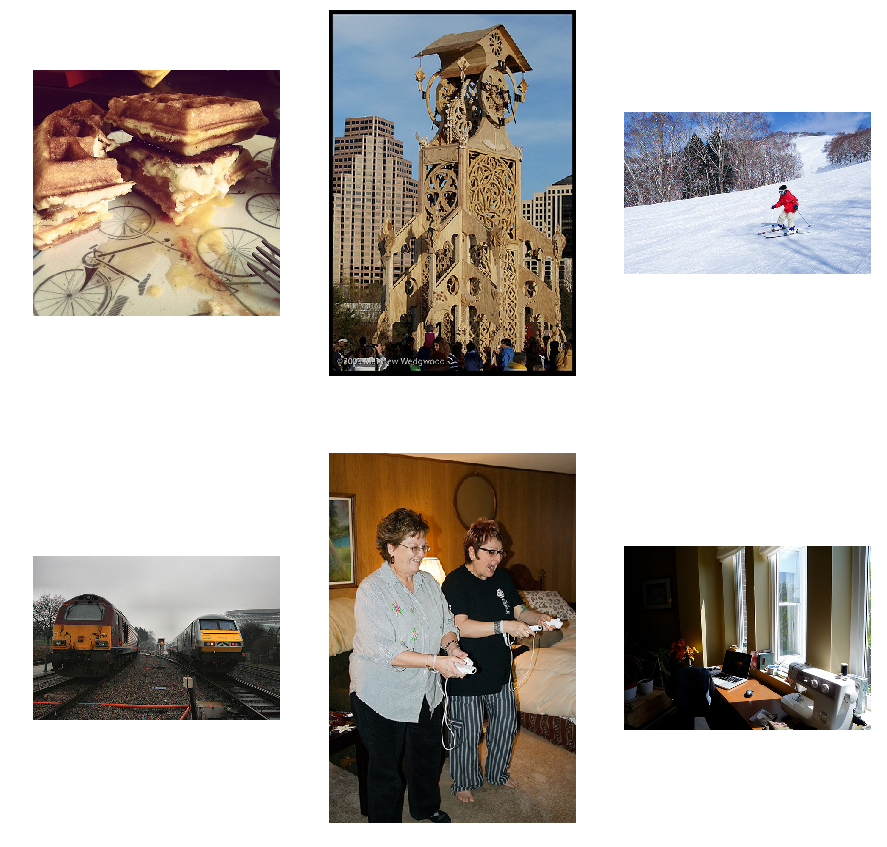

In [28]:
# A random sample of 6 images from Visual Genome
all_iis = df['vgimgdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'visual_genome', ii)

The direction of creation of the annotation hence is different to COCO, and more organic. Here, annotators were free to mark up regions of interest and to describe them; the objects to be marked in the image were then from taken from these descriptions. Consequently, the set of different object types is much larger in this corpus.

Going by the normalisation into WordNet synsets, the following is the number of different object types represented in the corpus:

In [29]:
len(df['vgobjdf']['syn'].unique())

8079

## ADE20k: Images categorised by scene type

A slightly different strand of research in computer vision is concerned with the categorisation of images according to the type of setting they show, with categories such as "bathroom", "garage", "park". The ADE20k corpus \cite{zhou2017scene} is a recent collection of that type. (The paper doesn't really say where the name ADE is coming from.)

> "There are 20,210 images in the training set, 2,000 images in the validation set, and 3,000 images in the testing set. All the images are exhaustively annotated with objects. Many objects are also annotated with their parts. For each object there is additional information about whether it is occluded or cropped, and other attributes. The images in the validation set are exhaustively annotated with parts, while the part annotations are not exhaustive over the images in the training set. [...]

> For our dataset, we are interested in having a diverse set of scenes with dense annotations of all the objects present. Images come from the LabelMe, SUN datasets, and Places and were selected to cover the 900 scene categories defined in the SUN database." \cite{zhou2017scene}

A property that is different from the corpora discussed so far is that here the annotation is meant to be *exhaustive*, that is, all objects that are in the image are segmented and labelled.

We were interested in this corpus because it makes possible the creation of an environment that (very roughly) simulates moving around from place to place. (See notebook in `03_Tasks`.)

**TODO** Remove hotfix once fixed properly.

116 ('training', 'b/bathroom', 'ADE_train_00000116.jpg')


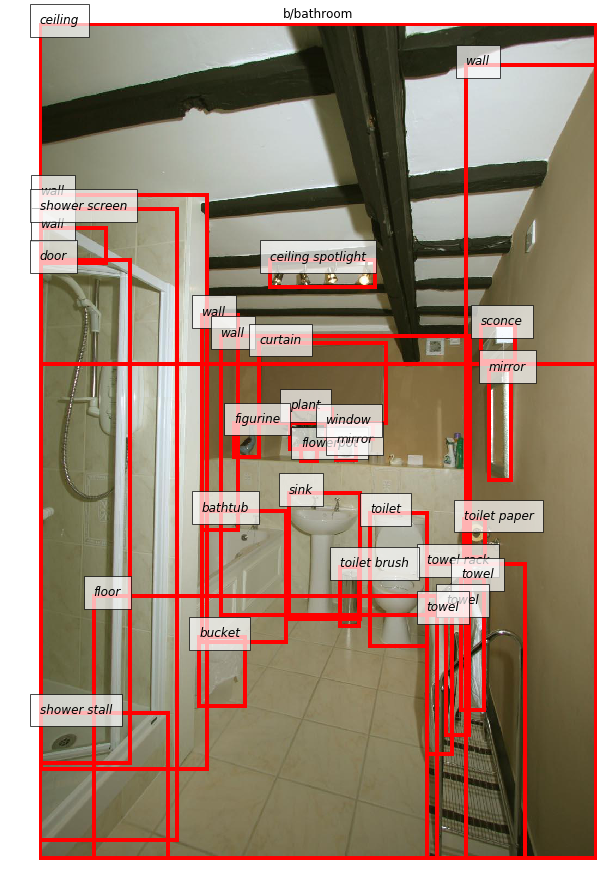

In [30]:
# show one image from ADE20k, with object bounding boxes

this_row = 115
ic, ii, cat, split, filename = df['ade_imgdf'].iloc[this_row][['i_corpus', 'image_id', 'image_cat', 'split', 'filename']]
full_ii = (split, cat, filename)
print(ii, full_ii)

# HOTFIX: drop_duplicates removes validation set annotations, which
#   in this version have non-unique image_ids and region_ids.
bbs = df['ade_objdf'].drop_duplicates(subset=['image_id', 'region_id'])\
    .query('(image_id == @ii) & (level == 0)')['bb label'.split()].values

plot_labelled_bb(
    get_image_filename(config, ic, full_ii), bbs, title=cat
)

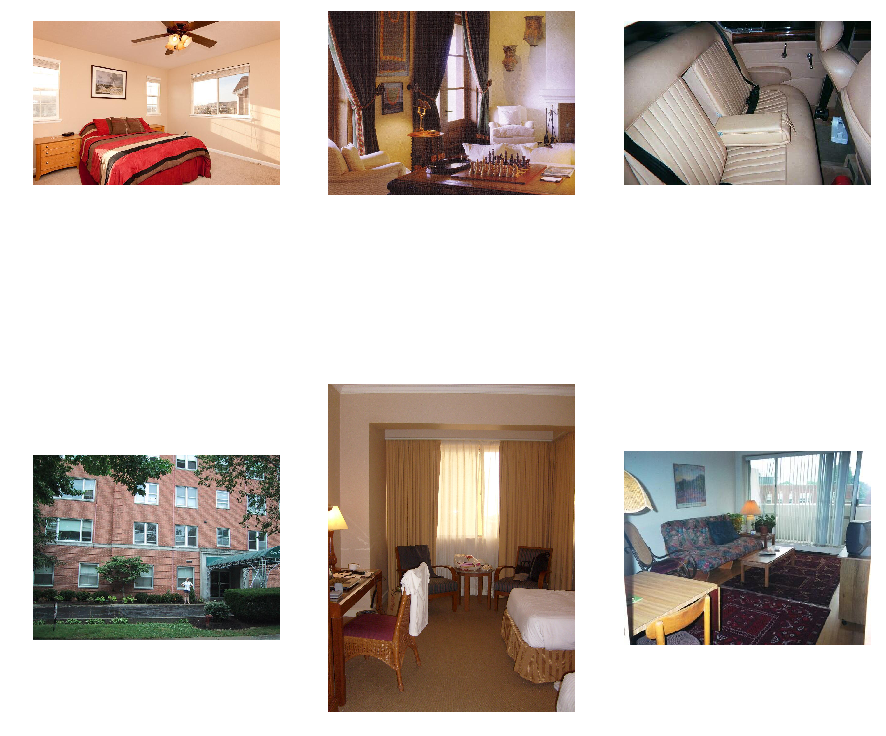

In [31]:
# A random sample of 6 images from ADE20k
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = df['ade_imgdf'].sample()['split image_cat filename'.split()].values[0]
        plot_img_ax(config, ax[n,m], 'ade_20k', ii)

In [32]:
df['ade_objdf']['synset'].value_counts()[:30]

window                                                 36344
wall                                                   30933
person, individual, someone, somebody, mortal, soul    21147
tree                                                   17800
building, edifice                                      15524
door                                                   15322
car, auto, automobile, machine, motorcar               13583
chair                                                  12505
floor, flooring                                        10344
light, light source                                     9711
windowpane, window                                      9163
plant, flora, plant life                                9163
painting, picture                                       8446
ceiling                                                 7946
sky                                                     7695
table                                                   7365
cabinet                 

## CUB-200-2011: Birds

The final dataset that we look at here again has a very different focus. The "Caltech-UCSD Birds" dataset (CUB-200-2011; \cite{WahCUB_200_2011}) collects pictures of individual birds, categorised by bird species. It can hence be used for *fine-grained visual classification*, where subtle differences are required to make a classification decision.

Language comes in with the additional information that is available for the images. 
\cite{Reed2016} collected 10 "fine grained visual descriptions" for each image: 

> "We asked workers to describe only visual appearance in at least 10 words, to avoid figures of speech, to avoid naming the species even if they knew it, and not to describe the background or any actions being taken. The prompt included three example sentences and a diagram labeling spe- cific parts of a bird (e.g. tarsus) and flower (e.g. stamen) so that non-experts could describe many different aspects without reference to external sources such as Wikipedia. Workers were not told the species."

symbolic information about bird:
      has_bill_shape: hooked
            has_size: small_(5_-_9_in)
           has_shape: upright-perching_water-like
   has_primary_color: grey
   has_primary_color: black
   has_primary_color: white
----------------------------------------------------------------------
fine-grained descriptions:
>  this bird has a white body and head with black feathers and a long pointy beak.
>  a bird with a large, downward curved orange bill, white breast and black wings.
>  a white bird with a black secondaries with a pink a gray bill
>  this large bird has a white head and underside, brown feathering along the back and wings, with a long bill that curves at the tip.
>  this is a white bird with a brown wing and a long pointy beak.
>  a medium sized bird with a long yellow pointed bill, black eyes, a white head, breast and abdomen, and grey wings.
>  a white, medium-sized bird with a long, yellow beak with a dark, downward point at the tip, dark brown wings, dark 

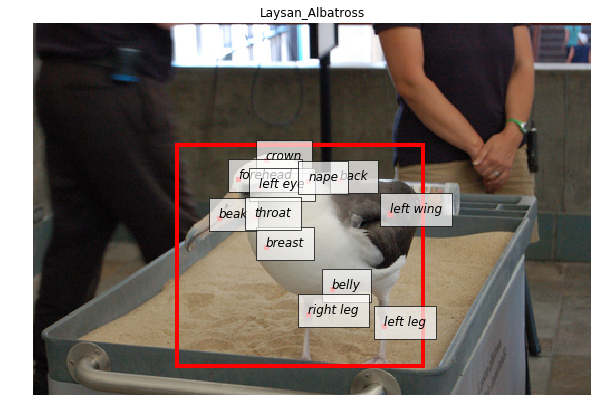

In [33]:
# A random bird, and information about it
def att2avm(cub_attrdf, image_id):
    subdf = cub_attrdf[cub_attrdf['image_id'] == image_id][['att', 'val']]
    out = []
    for _, row in subdf.iterrows():
#        print row
        out.append('{:>20}: {}'.format(row['att'], row['val']))
    return '\n'.join(out)

this_row = 115
ic, ii, path, cat, bb = df['cub_bbdf'].iloc[this_row][
    ['i_corpus', 'image_id', 'image_path', 'category', 'bb']]

all_parts = df['cub_partdf'][df['cub_partdf']['image_id'] == ii]
bbs = [((x, y, 1, 1), label) for label, x, y in all_parts['part_name x y'.split()].values]

print('symbolic information about bird:')
print(att2avm(df['cub_attrdf'], ii))
print('-' * 70)

print('fine-grained descriptions:')
for cap in df['cub_capdf'][df['cub_capdf']['image_id'] == ii]['caption'].tolist():
    print('> ', cap)
    
plot_labelled_bb(
    get_image_filename(config, ic, path), bbs + [(bb, '')], title=cat
)

**TODO:** Add our category-level information.

# References

[<a id="cit-Grubinger2006" href="#call-Grubinger2006">1</a>] M. Grubinger, P. Clough, H. M\"{u}ller <em>et al.</em>, ``_The IAPR TC-12 benchmark: a new evaluation resource for visual information systems_'', Proceedings of the International Conference on Language Resources and Evaluation (LREC 2006),  2006.

[<a id="cit-Escalante2010" href="#call-Escalante2010">2</a>] Escalante Hugo Jair, Hern\'{a}ndez Carlos a., Gonzalez Jesus a. <em>et al.</em>, ``_The segmented and annotated IAPR TC-12 benchmark_'', Computer Vision and Image Understanding, vol. 114, number 4, pp. 419--428,  2010.  [online](http://dx.doi.org/10.1016/j.cviu.2009.03.008)

[<a id="cit-Kazemzadeh2014" href="#call-Kazemzadeh2014">3</a>] S. Kazemzadeh, V. Ordonez, M. Matten <em>et al.</em>, ``_ReferItGame: Referring to Objects in Photographs of Natural Scenes_'', Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP 2014),  2014.

[<a id="cit-youngetal:flickr30k" href="#call-youngetal:flickr30k">4</a>] Young Peter, Lai Alice, Hodosh Micah <em>et al.</em>, ``_From image descriptions to visual denotations: New similarity metrics for semantic inference over event descriptions_'', Transactions of the Association for Computational Linguistics, vol. 2, number , pp. ,  2014.

[<a id="cit-Hodosh:flickr8k" href="#call-Hodosh:flickr8k">5</a>] Hodosh Micah, Young Peter and Hockenmaier Julia, ``_Framing image description as a ranking task: Data, models and evaluation metrics_'', Journal of Artificial Intelligence Research, vol. 47, number , pp. 853--899,  2013.  [online](http://www.scopus.com/inward/record.url?eid=2-s2.0-84883394520{\&}partnerID=tZOtx3y1)

[<a id="cit-flickr30kent" href="#call-flickr30kent">6</a>] B. A., L. Wang, C. M. <em>et al.</em>, ``_Flickr30k Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models_'', Proceedings of ICCV,  2015.

[<a id="cit-mscoco" href="#call-mscoco">7</a>] Tsung-Yi Lin, Michael Maire, Serge Belongie <em>et al.</em>, ``_Microsoft COCO: Common Objects in Context_'',  2014.

[<a id="cit-krishnavisualgenome" href="#call-krishnavisualgenome">8</a>] R. Krishna, Y. Zhu, O. Groth <em>et al.</em>, ``_Visual Genome: Connecting Language and Vision Using Crowdsourced Dense Image Annotations_'', ,  2016.  [online](https://arxiv.org/abs/1602.07332)

[<a id="cit-fellbaum:wordnet" href="#call-fellbaum:wordnet">9</a>] , ``_WordNet: An Electronic Lexical Database_'',  1998.

[<a id="cit-krauseetal:visgenparas" href="#call-krauseetal:visgenparas">10</a>] J. Krause, J. Johnson, R. Krishna <em>et al.</em>, ``_A hierarchical approach for generating descriptive image paragraphs_'', Proceedings - 30th IEEE Conference on Computer Vision and Pattern Recognition, January 2017.

[<a id="cit-Hudson2019" href="#call-Hudson2019">11</a>] Hudson Drew A and Manning Christopher D, ``_GQA : a new dataset for compositional question answering over real-world images_'', ArXiv, vol. , number , pp. ,  2019.

[<a id="cit-zhou2017scene" href="#call-zhou2017scene">12</a>] B. Zhou, H. Zhao, X. Puig <em>et al.</em>, ``_Scene Parsing through ADE20K Dataset_'', Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR),  2017.

[<a id="cit-WahCUB_200_2011" href="#call-WahCUB_200_2011">13</a>] C. Wah, S. Branson, P. Welinder <em>et al.</em>, ``The Caltech-UCSD Birds-200-2011 Dataset'', California Institute of Technology, number: CNS-TR-2011-001,   2011.

[<a id="cit-Reed2016" href="#call-Reed2016">14</a>] S. Reed, Z. Akata, B. Schiele <em>et al.</em>, ``_Learning Deep Representations of Fine-grained Visual Descriptions_'', Proceedings of the International Conference on Computer Vision and Pattern Recognition (CVPR),  2016.  [online](http://arxiv.org/abs/1605.05395)

